<a href="https://colab.research.google.com/github/luksaana/Brain-tumor-detection/blob/main/Brain_tumor_detection_on_MR_images_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diplomski rad: **Uspostavljanje dijagnoze primjenom umjetnih neuronskih mreža na snimkama magnetne rezonance mozga**, 2022.godina Student: Ana Lukša

Skup podataka: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import io
import keras
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
from keras.preprocessing import image
import shutil
import matplotlib.cm as cm
from IPython.display import display,clear_output

Priprema podataka

Za početak je potrebno napraviti analizu podatka. Skup podataka podijeljen je na skup za treniranje i skup za testiranje u omjeru 9:1.

Oba su podijeljena u još 4 podskupa: slike bez tumora te slike s gliomom, meningeomom i tumorom hipofize.


In [ ]:
# povezivanje s Google Drive-om za spremanje datoteka
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# provjera broja slika za svaku klasu i sveukupan broj slika za treniranje

meningeoma_tumor_train = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Training/meningioma_tumor'))
glioma_tumor_train = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Training/glioma_tumor'))
pituitary_tumor_train = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Training/pituitary_tumor'))
no_tumor_train = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Training/no_tumor'))
                                  
print("Number of images for each class (training)")
print("\nmeningeoma tumor:" , meningeoma_tumor_train)
print("glioma tumor:" , glioma_tumor_train)
print("pituitary tumor:" , pituitary_tumor_train)
print("no tumor:" , no_tumor_train)
print("-------------------------")
print("sum:" , meningeoma_tumor_train + glioma_tumor_train + pituitary_tumor_train +  no_tumor_train)

Number of images for each class (training)

meningeoma tumor: 822
glioma tumor: 826
pituitary tumor: 827
no tumor: 395
-------------------------
sum: 2870


In [ ]:
# provjera broja slika za svaku klasu i sveukupan broj slika za testiranje

meningeoma_tumor_test = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Testing/meningioma_tumor'))
glioma_tumor_test = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Testing/glioma_tumor'))
pituitary_tumor_test = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Testing/pituitary_tumor'))
no_tumor_test = len(os.listdir('/content/drive/MyDrive/Diplomski/MR brain tumor/Testing/no_tumor'))
                                  
print("Number of images for each class (testing)")
print("\nmeningeoma tumor:" , meningeoma_tumor_test)
print("glioma tumor:" , glioma_tumor_test)
print("pituitary tumor:" , pituitary_tumor_test)
print("no tumor:" , no_tumor_test)
print("-------------------------")
print("sum:" , meningeoma_tumor_test + glioma_tumor_test + pituitary_tumor_test +  no_tumor_test)

Number of images for each class (testing)

meningeoma tumor: 115
glioma tumor: 100
pituitary tumor: 74
no tumor: 105
-------------------------
sum: 394


In [ ]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [ ]:
# kreiranje direktorija za podatke za trening, testiranje i validaciju

train_dir = 'train_dir'
os.mkdir(train_dir)

test_dir = 'test_dir'
os.mkdir(test_dir)

val_dir = 'val_dir'
os.mkdir(val_dir)

In [ ]:
# u svakom direktoriju potrebno je kreirati direktorije za podatke svake klase

glioma_tumor = os.path.join(train_dir, 'glioma_tumor')
os.mkdir(glioma_tumor)
meningioma_tumor = os.path.join(train_dir, 'meningioma_tumor')
os.mkdir(meningioma_tumor)
no_tumor = os.path.join(train_dir, 'no_tumor')
os.mkdir(no_tumor)
pituitary_tumor = os.path.join(train_dir, 'pituitary_tumor')
os.mkdir(pituitary_tumor)

glioma_tumor = os.path.join(test_dir, 'glioma_tumor')
os.mkdir(glioma_tumor)
meningioma_tumor = os.path.join(test_dir, 'meningioma_tumor')
os.mkdir(meningioma_tumor)
no_tumor = os.path.join(test_dir, 'no_tumor')
os.mkdir(no_tumor)
pituitary_tumor = os.path.join(test_dir, 'pituitary_tumor')
os.mkdir(pituitary_tumor)

glioma_tumor = os.path.join(val_dir, 'glioma_tumor')
os.mkdir(glioma_tumor)
meningioma_tumor = os.path.join(val_dir, 'meningioma_tumor')
os.mkdir(meningioma_tumor)
no_tumor = os.path.join(val_dir, 'no_tumor')
os.mkdir(no_tumor)
pituitary_tumor = os.path.join(val_dir, 'pituitary_tumor')
os.mkdir(pituitary_tumor)

In [ ]:
# podatke iz dobivenih skupa za treniranje i testiranje podijeliti u podatke za treniranje, validaciju i testiranje

img_path = '/content/drive/MyDrive/Diplomski/MR brain tumor/Training/'
for category in os.listdir(img_path):
    if not category.startswith('.'):
        img_num = len(os.listdir(img_path + category))
        for (n, fname) in enumerate(os.listdir(img_path + category)):
            img = img_path + category + '/' + fname
            if n < 0.9*img_num:
                shutil.copy(img, 'train_dir/'+ category + '/' + fname)
            else:
                shutil.copy(img, 'val_dir/'+ category + '/' + fname)

In [ ]:
img_path = '/content/drive/MyDrive/Diplomski/MR brain tumor/Testing/'
for category in os.listdir(img_path):
    if not category.startswith('.'):
        img_num = len(os.listdir(img_path + category))
        for (n, fname) in enumerate(os.listdir(img_path + category)):
            img = img_path + category + '/' + fname
            shutil.copy(img, 'test_dir/'+ category + '/' + fname)

In [ ]:
# dodavanje svih slika iz direktorija na python popis, odredivanje dimenzije te pretvaranje slika u numpy nizove

def load_data(dir_path):
    x = []
    y = []
    image_size = 224
    for i in labels:
      folderPath = os.path.join(dir_path,i)
      for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x.append(img)
        y.append(i)

    x = np.array(x)
    y = np.array(y)
    print(f'{len(x)} images loaded from {dir_path} directory.')
    return x, y

In [ ]:
train_dir = 'train_dir/'
test_dir = 'test_dir/'
val_dir = 'val_dir/'

In [ ]:
# pomoćnom funkcijom učitati podatke slika

x_train, y_train = load_data(train_dir)
x_test, y_test = load_data(test_dir)
x_val, y_val = load_data(val_dir)

100%|██████████| 745/745 [00:02<00:00, 260.48it/s]


2585 images loaded from train_dir/ directory.


100%|██████████| 74/74 [00:00<00:00, 142.28it/s]


394 images loaded from test_dir/ directory.


100%|██████████| 82/82 [00:00<00:00, 276.13it/s]


285 images loaded from val_dir/ directory.


In [ ]:
# nekoliko naziva datoteka iz skupa za testiranje -> ne sadrže oznake klasa

os.listdir('test_dir/meningioma_tumor')[0:5]

['image(96).jpg',
 'image(29).jpg',
 'image(73).jpg',
 'image(71).jpg',
 'image(44).jpg']

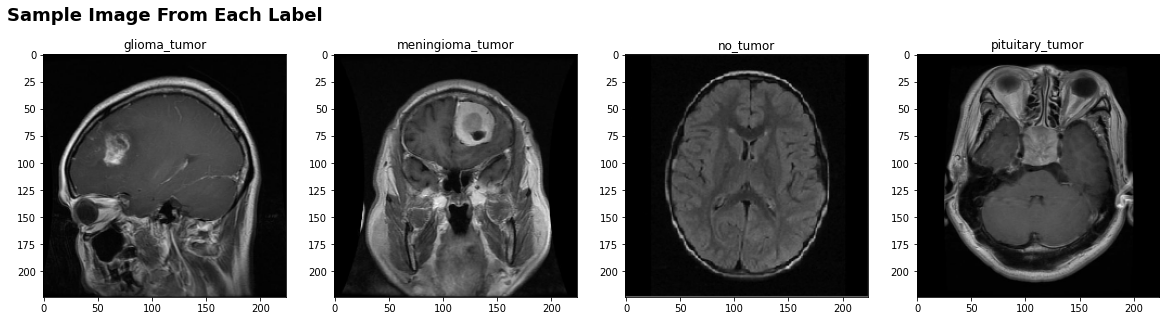

In [ ]:
# primjer slike iz svake klase

fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold', y=0.61,x=0.1)
k=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(x_train[j])
            ax[k].set_title(y_train[j])
            k+=1
            break
        j+=1

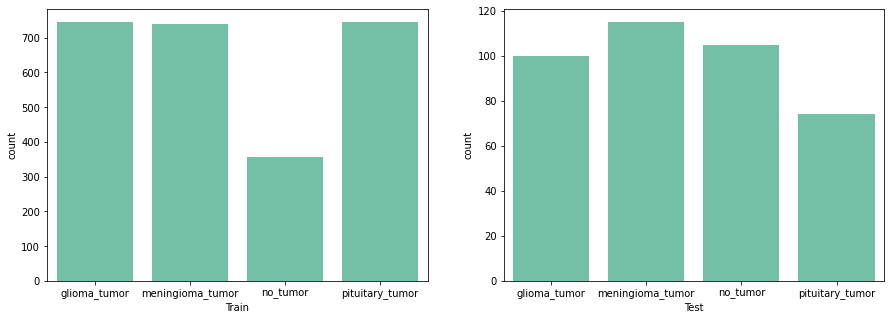

In [ ]:
# Vizualizacija distribucije skupa podataka: 
# na grafikonu je vidljivo da je broj slika bez tumora puno manji od ostalih. 
# Za postizanje što boljih rezultata treniranja modela poželjno je imati ravnomjernu distribuciju podataka u svim klasama.

plt.figure(figsize = (15,5));
lis = ['Train', 'Test']
for i,j in enumerate([y_train, y_test]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j, color="mediumaquamarine");
    plt.xlabel(lis[i])

In [ ]:
# pretvaranje labela u brojeve i one hot kodiranje

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [ ]:
# Kako bi broj slika u svakoj mapi bio približno isti potrebno je izvršiti augmentaciju slika bez tumora.

# privremeni direktorij za augmentirane slike
augmented_dir = 'augmented_dir'
os.mkdir(augmented_dir)

# direktorij za pohranu slika iz baznog direktorija
img_dir = os.path.join(augmented_dir, 'img_dir' )
os.mkdir(img_dir)

# lista svih slika klase bez tumora u skupu za treniranje
img_list = os.listdir('train_dir/no_tumor')

# kopiranje slika iz baznog direktorija u img_dir
for i in img_list:
  src = os.path.join('train_dir/no_tumor', i)
  dst = os.path.join(img_dir, i)
  shutil.copyfile(src, dst)

# direktorij koji sadrži slike
path = augmented_dir
save_path = 'train_dir/no_tumor'

# generator podataka za augmentiranje
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(224, 224))
 
# dodavanje augmentiranih slika u odgovarajući direktorij
# s obzirom da preostale klase sadrže oko 744 slika, poželjno je da i klasa bez tumora sadrži toliko
target_num = 744
img_num = len(os.listdir(img_dir))
batch_size = 32
num_batches = int(np.ceil((target_num - img_num) / batch_size))
    
for i in range(0, num_batches):
    imgs, labels = next(aug_datagen)

# brisanje privremenog direktorija
shutil.rmtree('augmented_dir')

Found 356 images belonging to 1 classes.


In [ ]:
# ponovno provjeriti broj slika bez tumora te ukupan broj slika za treniranje nakon augmentacije

aug_no_tumor = len(os.listdir('train_dir/no_tumor'))
print("no tumor:" , aug_no_tumor)
print("sum (training images in train_dir):" , meningeoma_tumor_train + glioma_tumor_train + pituitary_tumor_train +  aug_no_tumor)

no tumor: 744
sum (training images in train_dir): 3219


In [ ]:
# Pripremanje podatka pomoću generatora:
# Augumentacija - transformacije se koriste samo na skupu za treniranje, dok validacijski i testni skup ostaju isti.

train_datagen=ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=50)


val_datagen = ImageDataGenerator()
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32)


test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32)

Found 2973 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


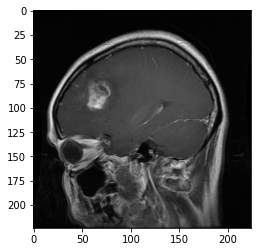

In [ ]:
# prikaz jedne originalne slike
plt.imshow(x_train[0])
plt.show()

In [ ]:
# sliku je potrebno pretvoriti u numpy array format (H, W, C) tj. u (224, 224, 3) 
x = image.img_to_array(x_train[0])
# dodavanjejoš jedne dimenzije jer je potrebna informacija o veličini podskupa (1, 224, 224, 3)
x = x.reshape((1,) + x.shape)
print(x.shape)

(1, 224, 224, 3)


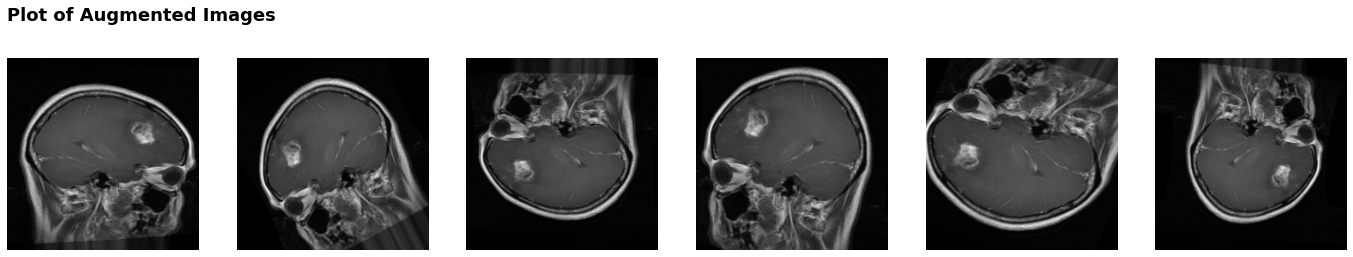

In [ ]:
# .flow() beskonačno generira podskupove augmentiranih podataka
# prikaz prvih nekoliko slika

fig, ax = plt.subplots(nrows=1,ncols=6, figsize=(24,24))
fig.text(s='Plot of Augmented Images',size=18,fontweight='bold', y=0.58,x=0.125)
for k in range(5):
    i = 0
    for batch in train_datagen.flow(x, batch_size=1):
        ax[k].imshow(image.array_to_img(batch[0]))
        ax[k].axis('off')
        i += 1
        k=i
        if i>5:
            break
    plt.show()

**Izrada vlastitog modela za klasifikaciju tumora na snimkama magnetne rezonance mozga**


In [ ]:
# kod izrade modela bez transfernog učenja potrebno je učitati sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), padding= 'same', activation='relu', input_shape = (224,224,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 4, activation='softmax'))
model.summary()

**Treniranje modela**

Model je treniran sa serijama od 50 uzoraka i postavljen je za rad na 20 epoha,

Zbog zadatka višeklasne klasifikacije koristi se funkcija gubitka "categorical_crossentropy", a kao optimizator je odabram ADAM.


In [ ]:
# optimizacijski algoritam, funckiju gubitka i metrike praćene tijekom treniranja odabiru se u metodi compile

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
# gdje će se spremiti model

filepath_model = "/content/drive/MyDrive/Diplomski/model.h5"

In [ ]:
# povratni pozivi

# generira zapise koji se kasnije mogu pokrenuti za vizualizaciju treninga
tensorboard = TensorBoard(log_dir = 'logs')

# spremanje modela na temelju metrike tijekom treniranja
checkpoint = ModelCheckpoint("filepath_model", monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# kada se metrika prestane poboljšavati, smanjit će se učenje
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
# rezultati treniranja spremaju se u varijablu kako bi se kasnije prikazali grafički
history = model.fit(train_generator, validation_data=validation_generator, epochs = 20, verbose=1,
                      callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
# funkcija za grafički prikaz rezultata

def plot_history_acc_loss(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, marker='o',color= 'r', label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',color= 'b', label = 'Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    sns.despine()
    ax[1].plot(epochs, train_loss, marker='o', color= 'r', label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o', color= 'b', label = 'Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')
    ax[1].legend()

    fig.show()

In [ ]:
# grafički prikaz rezultata treniranja: točnost i gubitak
plot_history_acc_loss(history)

**Predikcija** i **evalucija** modela na skupu podataka za testiranje

**GradCAM**

In [ ]:
# predviđanje modela

# 0 - Glioma Tumor
# 1 - Meningioma Tumor
# 2 - No Tumor
# 3 - Pituitary Tumor

# predvidjeti distribuciju vjerojatnosti podataka
pred = model.predict(x_test)

# klasa s najvećom vjerojatnošću za svaki uzorak
pred = np.argmax(pred,axis=1)

y_test_new = np.argmax(y_test, axis=1)

# izvješće o klasifikaciji
print(classification_report(y_test_new , pred))


              precision    recall  f1-score   support

           0       0.95      0.18      0.30       100
           1       0.64      0.84      0.73       115
           2       0.66      0.99      0.79       105
           3       0.82      0.73      0.77        74

    accuracy                           0.69       394
   macro avg       0.77      0.69      0.65       394
weighted avg       0.76      0.69      0.65       394



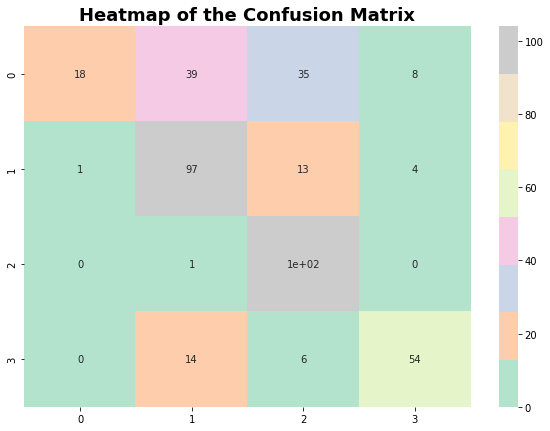

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Heatmap of the Confusion Matrix', size=18, fontweight='bold', color='black')
sns.heatmap(confusion_matrix(y_test_new, pred), annot=True, cmap=("Pastel2"))

In [ ]:
# evaluacija na skupu za testiranje
test_loss, test_acc = model.evaluate(test_generator)
print('"The accuracy of the model is:": {:.2f}%'.format(test_acc*100))
print('"The loss of the model is:": {:.6f}'.format(test_loss))

13/13 [==============================] - 11s 853ms/step - loss: 2.6094 - accuracy: 0.7030
"The accuracy of the model is:": 70.30%
"The loss of the model is:": 2.609440


In [ ]:
# izdvajanje lažno negativnih 

def extract_false_neg(model, data, labels):
  false_predictions = []
  for img, label in zip(data, labels):
    image = image = tf.expand_dims(img, axis=0)
    predicted = model.predict(image)
    predicted_label = np.argmax(predicted)
    true_label= np.argmax(label)
    confidence = predicted[0][predicted_label]

    if true_label != predicted_label:
      false_predictions.append([img, true_label, predicted_label, confidence, predicted])
  return false_predictions

In [ ]:
false_predictions = extract_false_neg(model, x_test, y_test)
print(len(false_predictions))

121


In [ ]:
last_layer_name = 'conv2d_13'

In [ ]:
def get_img_array(img):
    array = keras.preprocessing.image.img_to_array(img)
    # dodavanje dimenzije za transformaciju niza u seriju
    # veličine (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # izrada modela koji mapira ulaznu sliku na aktivacije
    # posljednjeg konvolucijskog sloja i izlaza predviđanja
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output])
    # izračunavanje gradijenta najviše predviđene klase za ulaznu sliku
    # s obzirom na aktivacije posljednjeg sloja konv
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    # gradijent izlaznog neurona (gornji predviđeni ili odabrani)
    # s obzirom na izlaznu mapu značajki posljednjeg konvolucijskog sloja
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # vektor gdje je svaki unos srednji intenzitet gradijenta
    # preko određenog kanala mape značajki
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # svaki kanal u nizu mape značajki se množi
    # prema važnosti kanala s obzirom na najvišu predviđenu klasu
    # zatim se zbroje svi kanali kako bi dobili aktivaciju klase toplinske mape
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # U svrhu vizualizacije, također ćemo normalizirati toplinsku mapu između 0 i 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,preds=[0,0,0,0], plot=None):

    # ponovno skaliranje toplinske mape na raspon 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # koristi se jet colormap za bojanje heatmapa
    jet = cm.get_cmap("jet")

    # koriste se RGB vrijednosti karte boja
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # stvaranje slike s RGB toplinskom mapom u boji
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # toplinska mapa preko izvorne slike
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # prikaz Grad CAM
    plot.imshow(superimposed_img)
    plot.axis('off')

In [ ]:
def heatmap_plot(false_predictions, model, last_conv_layer_name):
  for i, sample in enumerate(false_predictions):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 10))
    plt.subplots_adjust(bottom=0)
    true_label= np.argmax(y_train)
    img, true_label, predicted_label, trust, prediction = sample[0], sample[1], sample[2], sample[3], sample[4][0]    

    im_class = labels[true_label]
    true_label_class = r"True Label: $\bf{" + str(labels[true_label]) + "}$"
    predicted_label_class = r"Predicted Label: $\it{"+ str(labels[predicted_label]) + "}$"

    confidence = "Confidence: " + str(trust)

    img_array = get_img_array(img)
    # maknuti softmax zadnjeg sloja
    model.layers[-1].activation = None
    # ispisati koja je najviše predviđena klasa
    preds = model.predict(img_array)
    title = "{} \n {} \n {} \n".format(
        true_label_class, predicted_label_class, confidence)
    plt.axis('off')
    heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.reshape(heatmap, (7,7))
    display_gradcam(img, heatmap, preds=preds[0], plot=ax1)
    _ = ax2.imshow(img)
    _ = ax3.imshow(heatmap)
    ax1.set_title("GradCam")
    ax2.set_title(title)
    ax3.set_title('Attention Map')
    plt.show()
    plt.close()
    print('------------------------------------------------------------------------------------------------------------------------------------------------------')

In [ ]:
heatmap_plot(false_predictions, model, last_layer_name)

**Transferirano učenje**

Uobičajena je i učinkovita strategija za treniranje mreže na malom skupu podataka, gdje je mreža unaprijed obučena na iznimno velikom skupu podataka, kao što je ImageNet, koji sadrži 1,4 milijuna slika s 1000 klasa, zatim se ponovno koristi i primjenjuje na zadani zadatak interesa, u ovom slučaju klasificiranje tumora mozga na snimkama magnetske rezonance.

Za ovaj rad korištene su 4 poznate arhitekture neuronskih mreža: EfficientNetB0, ResNet50v2, Inception i Xception.


**EfficientNetB0 network**

Model

Za izradu prvog modela kao baza korišten je EfficientNetB0 te su dodani:

-sloj sažimanja MaxPooling - 2D jer su slike dvodimenzionalne

-Flatten, sloj za ravnanje

-Dropout, za ispuštanje 50% neurona

-Dense, gusti sloj

In [ ]:
# prvo je potrebno učitati model
# bez potpuno povezanih izlaznih slojeva modela, sa težinom imagenet i ulaznim tenzorom 224x224 sa kanala 3  

effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model1 = effnet.output
model1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(model1)
model1 = tf.keras.layers.Flatten()(model1)
model1 = tf.keras.layers.Dropout(rate=0.5)(model1)
model1 = tf.keras.layers.Dense(units = 4, activation='softmax')(model1)
model1 = tf.keras.models.Model(inputs=effnet.input, outputs = model1)
model1.summary()

In [ ]:
# kompliranje modela prije treniranja

model1.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
filepath_effnet = "/content/drive/MyDrive/Diplomski/effnet.h5"

In [ ]:
# određivanje povratnih poziva
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath_effnet, monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
# treniranje mreže
history1 = model1.fit(train_generator, validation_data=validation_generator, epochs = 12, verbose=1,
                      callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
# grafički prikaz rezultata treniranja: točnost i gubitak
plot_history_acc_loss(history1)

In [ ]:
# predviđanje modela

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

pred1 = model1.predict(x_test)
pred1 = np.argmax(pred1,axis=1)
y_test_new = np.argmax(y_test, axis=1)


# izvješće o klasifikaciji
print(classification_report(y_test_new, pred1))

              precision    recall  f1-score   support

           0       0.88      0.38      0.53       100
           1       0.72      0.97      0.83       115
           2       0.82      0.99      0.90       105
           3       0.94      0.86      0.90        74

    accuracy                           0.81       394
   macro avg       0.84      0.80      0.79       394
weighted avg       0.83      0.81      0.78       394



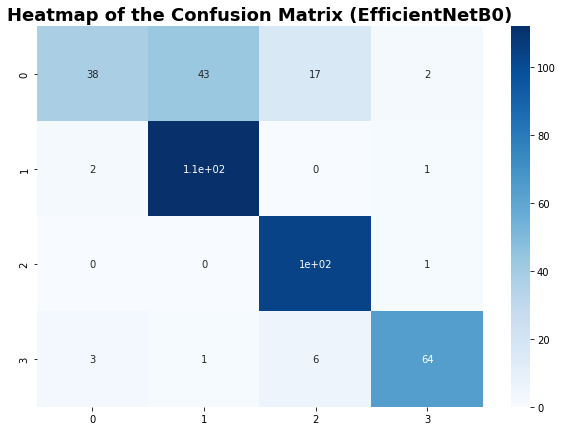

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Heatmap of the Confusion Matrix (EfficientNetB0)', size=18, fontweight='bold', color='black')
sns.heatmap(confusion_matrix(y_test_new, pred1), annot=True, cmap=("Blues"))

In [ ]:
# evaluacija na skupu za testiranje
test_loss1, test_acc1 = model1.evaluate(test_generator)
print('"The accuracy of the model is:": {:.2f}%'.format(test_acc1*100))
print('"The loss of the model is:": {:.6f}'.format(test_loss1))

13/13 [==============================] - 2s 114ms/step - loss: 1.3586 - accuracy: 0.8071
"The accuracy of the model is:": 80.71%
"The loss of the model is:": 1.358564


**Resnet50v2 network**

In [ ]:
# učitavanje Resnet50v2 modela

resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model2 = resnet.output
model2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.BatchNormalization()(model2)
model2 = tf.keras.layers.Dense(units = 256, activation='relu')(model2)
model2 = tf.keras.layers.Flatten()(model2)
model2 = tf.keras.layers.Dense(units = 4, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=resnet.input, outputs = model2)
model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
filepath_resnet = "/content/drive/MyDrive/Diplomski/resnet.h5"

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath_resnet, monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
history2 = model2.fit(train_generator, validation_data=validation_generator, epochs = 20, verbose=1,
                      callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
plot_history_acc_loss(history2)

In [ ]:
pred2 = model2.predict(x_test)
pred2 = np.argmax(pred2,axis=1)
y_test_new = np.argmax(y_test, axis=1)

# izvješće o klasifikaciji
print(classification_report(y_test_new, pred2))

              precision    recall  f1-score   support

           0       0.87      0.27      0.41       100
           1       0.72      0.92      0.81       115
           2       0.66      0.98      0.79       105
           3       0.95      0.78      0.86        74

    accuracy                           0.75       394
   macro avg       0.80      0.74      0.72       394
weighted avg       0.79      0.75      0.71       394



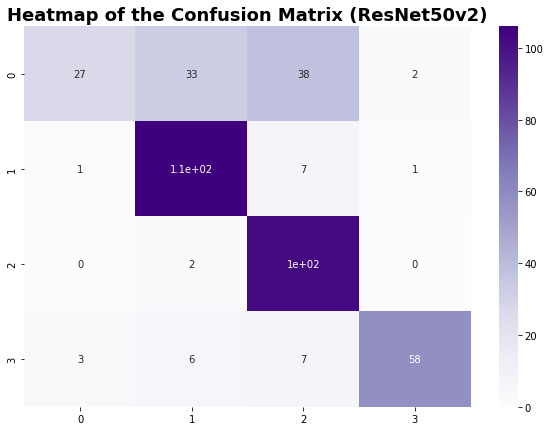

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Heatmap of the Confusion Matrix (ResNet50v2)', size=18, fontweight='bold', color='black')
sns.heatmap(confusion_matrix(y_test_new, pred2), annot=True, cmap=("Purples"))

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_generator)
print('"The accuracy of the model is:": {:.2f}%'.format(test_acc2*100))
print('"The loss of the model is:": {:.6f}'.format(test_loss2))

13/13 [==============================] - 2s 123ms/step - loss: 1.4378 - accuracy: 0.7437
"The accuracy of the model is:": 74.37%
"The loss of the model is:": 1.437821


**Inception network**

In [ ]:
#učitavanje inception modela

inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
model3 = inception.output
model3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(model3)
model3 = tf.keras.layers.Flatten()(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(units = 4, activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=inception.input, outputs = model3)
model3.summary()

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
filepath_inception = "/content/drive/MyDrive/Diplomski/inception.h5"

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath_inception ,monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
history3 = model3.fit(train_generator, validation_data=validation_generator, epochs = 20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
plot_history_acc_loss(history3)

In [ ]:
pred3 = model3.predict(x_test)
pred3 = np.argmax(pred3, axis=-1)
y_test_new = np.argmax(y_test, axis=1)

# izvješće o klasifikaciji
print(classification_report(y_test_new, pred3))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47       100
           1       0.70      0.99      0.82       115
           2       0.76      0.99      0.86       105
           3       1.00      0.85      0.92        74

    accuracy                           0.79       394
   macro avg       0.86      0.79      0.77       394
weighted avg       0.85      0.79      0.76       394



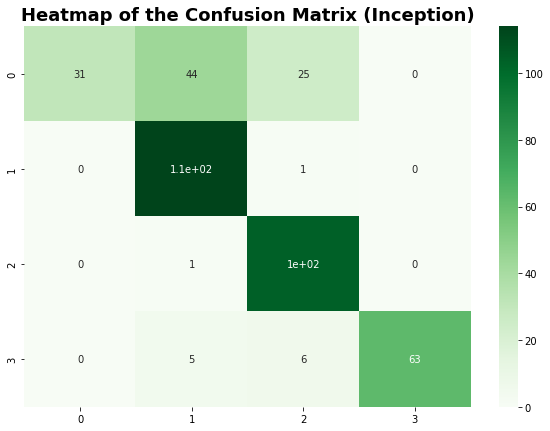

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Heatmap of the Confusion Matrix (Inception)', size=18, fontweight='bold', color='black')
sns.heatmap(confusion_matrix(y_test_new, pred3), annot=True, cmap=("Greens"))

In [ ]:
test_loss3, test_acc3 = model3.evaluate(test_generator)
print('"The accuracy of the model is:": {:.2f}%'.format(test_acc3*100))
print('"The loss of the model is:": {:.6f}'.format(test_loss3))

13/13 [==============================] - 2s 117ms/step - loss: 1.4646 - accuracy: 0.7868
"The accuracy of the model is:": 78.68%
"The loss of the model is:": 1.464637


**Xception network**

In [ ]:
xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model4 = xception.output
model4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(model4)
model4 = tf.keras.layers.Flatten()(model4)
model4 = tf.keras.layers.Dropout(rate=0.5)(model4)
model4 = tf.keras.layers.Dense(units = 4, activation='softmax')(model4)
model4 = tf.keras.models.Model(inputs=xception.input, outputs = model4)
model4.summary()

In [ ]:
model4.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
filepath_xception = "/content/drive/MyDrive/Diplomski/xception.h5"

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath_xception, monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
history4 = model4.fit(train_generator, validation_data=validation_generator, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
plot_history_acc_loss(history4)

In [ ]:
pred4 = model4.predict(x_test)
pred4 = np.argmax(pred4, axis=-1)
y_test_new = np.argmax(y_test, axis=1)

# izvješće o klasifikaciji
print(classification_report(y_test_new, pred4))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50       100
           1       0.67      0.99      0.80       115
           2       0.78      1.00      0.88       105
           3       1.00      0.77      0.87        74

    accuracy                           0.78       394
   macro avg       0.86      0.77      0.76       394
weighted avg       0.85      0.78      0.76       394



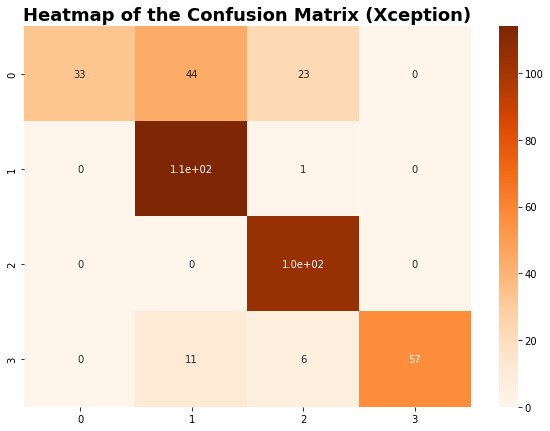

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Heatmap of the Confusion Matrix (Xception)', size=18, fontweight='bold', color='black')
sns.heatmap(confusion_matrix(y_test_new, pred4), annot=True, cmap=("Oranges"))

In [ ]:
test_loss4, test_acc4 = model4.evaluate(test_generator)
print('"The accuracy of the model is:": {:.2f}%'.format(test_acc4*100))
print('"The loss of the model is:": {:.6f}'.format(test_loss4))

13/13 [==============================] - 2s 135ms/step - loss: 1.4379 - accuracy: 0.7944
"The accuracy of the model is:": 79.44%
"The loss of the model is:": 1.437896
